In [1]:
#Import you usual Libraries
import numpy as np
import time
import matplotlib.pyplot as plt
from Gaus_Poly1_DDF import *
from matplotlib.animation import FuncAnimation

In [52]:
#Import the Data
SWE = np.load('ForcedSWE_10k_1e-1.npy').T

In [53]:
SWE.shape

(300, 10000)

In [35]:
D = 300              #Dimension of the system
length = 5000       #Time to train for
Xdata = SWE    #Which Data set to train on
TT = 0.1             #Time Scale of the Data
NoCenters = 1000     #Number of Centers


start_time = time.time()
DDF = GaussPoly1Mat()
Center = DDF.KmeanCenter(Xdata,NoCenters,D,length)
print("--- %s seconds ---" % (time.time() - start_time))
np.save('Centers_train10k_1k_D300.npy',Center)
#Center = np.load('Centers_train10k_1k_D1200.npy')

--- 78.18329286575317 seconds ---


In [36]:
PreLength = 5000    #Forecasting Time
beta,R = 1e-5, 1e-6 #Hyper Parameters Beta and R (Very Important!)


X = np.arange(0,PreLength*TT,TT)
start_time = time.time()
F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D)
print("--- %s seconds ---" % (time.time() - start_time))
Pred = DDF.PredictIntoTheFuture(F,PreLength,DDF.FinalX)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.311033248901367 seconds ---
--- 12.28503704071045 seconds ---


<function matplotlib.pyplot.show(close=None, block=None)>

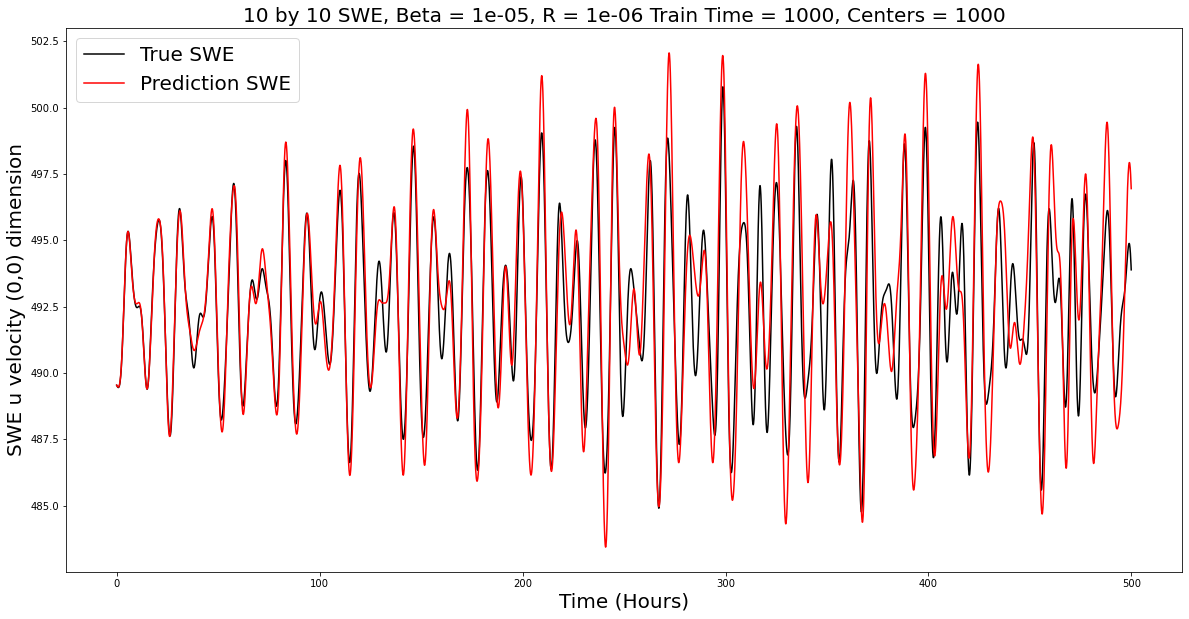

In [49]:
plt.figure(figsize=(20,10))
plt.plot(X,Xdata[200][length:length + PreLength],label = 'True SWE', color = 'black')
plt.plot(X,Pred[200],label = 'Prediction SWE', color = 'r')
plt.xlabel('Time (Hours)',fontsize=20)
plt.ylabel('SWE u velocity (0,0) dimension',fontsize=20)
plt.legend(fontsize=20)
plt.title('10 by 10 SWE, Beta = '+str(beta)+', R = '+str(R)+' Train Time = 1000, Centers = 1000',fontsize=20)
plt.savefig('10by10_Forced_Wind_SWE')
plt.show

In [50]:
for i in range(10):
    for j in range(10):
        PreLength = 5000
        X = np.arange(0,PreLength*TT,TT)
        beta,R = 10**(i-8), 10**(j-8)

        F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D)
        Pred = DDF.PredictIntoTheFuture(F,PreLength,DDF.FinalX)
        
        if True not in np.isnan(Pred):  #This just makes sure there aren't infinities in the prediction because matlab will return an error and stop the looping
            plt.figure(figsize=(20,10))
            plt.plot(X,Xdata[0][length:length + PreLength],label = 'True SWE', color = 'black')
            plt.plot(X,Pred[0],label = 'Prediction SWE', color = 'r')
            plt.xlabel('Time (Hours)',fontsize=20)
            plt.ylabel('SWE x velocity',fontsize=20)
            plt.legend()
            plt.title('SWE 0.1 time step, Beta = '+str(beta)+', R = '+str(R)+' Train Time = 10000, Centers = 1000',fontsize=20)
            plt.savefig('Ploti='+str(i)+'j='+str(j))
            plt.show

# Prediction Animation

In [40]:
DZ = 200 #This is the dimension the water height starts at (0-399 u, 400-799 v, 800-1199 z)
Zpred = Pred[DZ:]
ZTrue = Xdata[DZ:]
space = 10   #Tell Matlab the square grid size (in this case a 3 by 3)
stepsize = 5 #Choose how many time steps to skip before adding a new frame to the video
Frames = 1000 #Number of Frames in the video
minlevel = 485 #Water height level min
maxlevel = 505 #Water height level max


#Make the Prediction Animation
x = np.arange(0,space,1)
y = np.arange(0,space,1)
X,Y = np.meshgrid(x, y)
Z = np.zeros((space,space))
ZP = np.zeros((space,space))
ZT = np.zeros((space,space))

def animateppred(i):
    ax.clear()
    ax.set_title('DDF Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            ZP[j][l] = Zpred[j*space+l][i*stepsize]
    ax.plot_surface(X, Y, ZP, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

#Make the True Animation
def animatepTrue(i):
    ax.clear()
    ax.set_title('True Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            ZT[j][l] = ZTrue[j*space+l][length+i*stepsize]
    ax.plot_surface(X, Y, ZT, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    
    
#1 Wire Frame and 1 Surface
X,Y = np.meshgrid(x, y)
Z1 = np.zeros((space,space))
Z2 = np.zeros((space,space))

def animatepBoth(i):
    ax.clear()
    ax.set_title('True Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            Z1[j][l] = ZTrue[j*space+l][length+i*stepsize]
    for j in range(space):
        for l in range(space):
            Z2[j][l] = Zpred[j*space+l][i*stepsize]
    
    ax.plot_surface(X, Y, Z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    #ax.plot_surface(X, Y, Z2, rstride=1, cstride=1,
    #                cmap='binary', edgecolor='none')
    ax.plot_wireframe(X, Y, Z2, color='black')
    ax.set_title('surface');

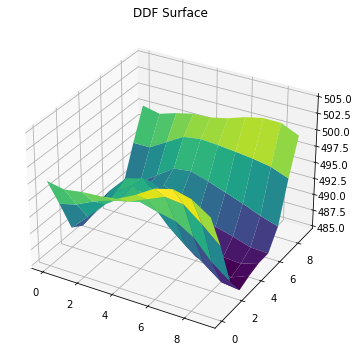

In [41]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animateppred, frames=Frames, interval=50, repeat=False)

ani.save('Pred_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

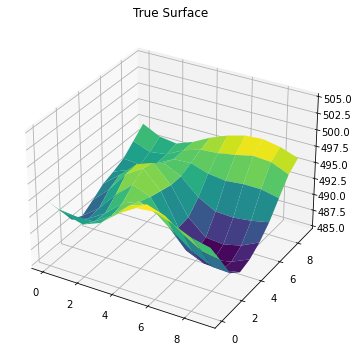

In [42]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animatepTrue, frames=Frames, interval=50, repeat=False)

ani.save('True_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

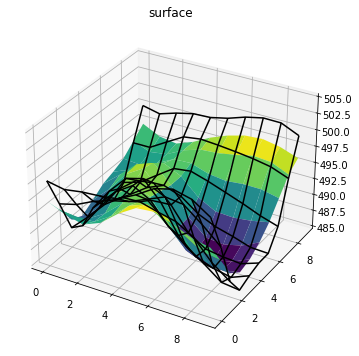

In [43]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animatepBoth, frames=Frames, interval=50, repeat=False)

ani.save('Both_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

# 3D Picture

In [44]:
Zpred = Pred[200:]
Zpred.shape

(100, 5000)

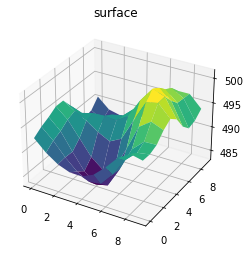

In [46]:
i = 1000
space = 10
x = np.arange(0,space,1)
y = np.arange(0,space,1)
X,Y = np.meshgrid(x, y)
Z = np.zeros((space,space))
for j in range(space):
    for l in range(space):
        Z[j][l] = Zpred[j*space+l][i]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');